In [1]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchmetrics import Precision, Recall, F1Score, Accuracy
from utils.model_architectures.cnn_custom import ConvNet
from utils.model_architectures.cnn_batchnorm import ConvNetWithBatchNorm
from utils.model_architectures.resnet_custom import CustomResNet

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize the images to 256x256
    transforms.ToTensor(),          # Convert the images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet statistics
])

# Load the full dataset
full_dataset = datasets.ImageFolder(root='data/dataset-resized', transform=transform)

In [4]:
# Create indices for the full dataset
indices = list(range(len(full_dataset)))

# First split: 80% training and 20% (test + validation)
train_indices, test_val_indices = train_test_split(indices, test_size=0.2, random_state=42)
# Second split: 50% validation, 50% test from the 20% split
val_indices, test_indices = train_test_split(test_val_indices, test_size=0.5, random_state=42)

# Create subsets using the indices
train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)
test_dataset = Subset(full_dataset, test_indices)

# Create DataLoaders for each subset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [5]:
num_classes=len(full_dataset.classes)

In [6]:
# model = CustomResNet(num_classes=num_classes)
# model = model.to(device)

In [7]:
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

/home/adavodet/PROJECTS/dechets_classification/trash_env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/adavodet/PROJECTS/dechets_classification/trash_env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [9]:
accuracy = Accuracy(task='multiclass', num_classes=num_classes).to(device)
precision = Precision(task='multiclass', average='macro', num_classes=num_classes).to(device)
recall = Recall(task='multiclass', average='macro', num_classes=num_classes).to(device)
f1_score = F1Score(task='multiclass', average='macro', num_classes=num_classes).to(device)

# Store metrics for visualization
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
train_precisions, val_precisions = [], []
train_recalls, val_recalls = [], []
train_f1_scores, val_f1_scores = [], []

In [10]:
num_epochs = 10

In [11]:
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    
    # Metrics storage for training specificity calculation
    train_labels = []
    train_preds = []

    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]")

    for inputs, labels in train_loader_tqdm:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)

         # Get predictions for metrics
        _, predicted = torch.max(outputs, 1)
        
        # Update metrics for training
        accuracy.update(predicted, labels)
        precision.update(predicted, labels)
        recall.update(predicted, labels)
        f1_score.update(predicted, labels)

        # Collect for specificity calculation
        train_labels.extend(labels.cpu().numpy())
        train_preds.extend(predicted.cpu().numpy())

        # Update tqdm with the current loss
        train_loader_tqdm.set_postfix(loss=loss.item())
    
    epoch_loss = running_loss / len(train_dataset)
    
    # Compute training metrics
    train_accuracy = accuracy.compute().item()
    train_precision = precision.compute().item()
    train_recall = recall.compute().item()
    train_f1_score = f1_score.compute().item()

    # Compute specificity for training
    TN = sum((np.array(train_labels) == 0) & (np.array(train_preds) == 0))
    FP = sum((np.array(train_labels) == 0) & (np.array(train_preds) != 0))

    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}, '
          f'Training Accuracy: {train_accuracy:.2f}, Precision: {train_precision:.2f}, '
          f'Recall: {train_recall:.2f}, F1 Score: {train_f1_score:.2f}')
    
    # Store training metrics
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    train_f1_scores.append(train_f1_score)
    
    # Reset training metrics for the next epoch
    accuracy.reset()
    precision.reset()
    recall.reset()
    f1_score.reset()
    
    # Validation phase
    model.eval()
    val_loss = 0.0

    # Metrics storage for validation specificity calculation
    val_labels = []
    val_preds = []
    
    with torch.no_grad():
        val_loader_tqdm = tqdm(val_loader, desc="Validation")
        for inputs, labels in val_loader_tqdm:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * inputs.size(0)
            
            _, predicted = torch.max(outputs, 1)
            
            # Update metrics for validation
            accuracy.update(predicted, labels)
            precision.update(predicted, labels)
            recall.update(predicted, labels)
            f1_score.update(predicted, labels)

            # Collect for specificity calculation
            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(predicted.cpu().numpy())
    
    val_loss /= len(val_dataset)

    # Compute validation metrics
    val_accuracy = accuracy.compute().item()
    val_precision = precision.compute().item()
    val_recall = recall.compute().item()
    val_f1_score = f1_score.compute().item()
    
    # Compute specificity for validation
    TN = sum((np.array(val_labels) == 0) & (np.array(val_preds) == 0))
    FP = sum((np.array(val_labels) == 0) & (np.array(val_preds) != 0))

    # Store validation metrics
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1_scores.append(val_f1_score)

    # Display metrics
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}, '
          f'Precision: {val_precision:.2f}, Recall: {val_recall:.2f}, F1 Score: {val_f1_score:.2f}')

    # Reset validation metrics for the next epoch
    accuracy.reset()
    precision.reset()
    recall.reset()
    f1_score.reset()

print('Training complete.')

Epoch [1/10]: 100%|██████████| 64/64 [00:16<00:00,  3.88it/s, loss=1.9]  


Epoch [1/10], Training Loss: 0.6387, Training Accuracy: 0.77, Precision: 0.75, Recall: 0.73, F1 Score: 0.74


Validation: 100%|██████████| 8/8 [00:01<00:00,  6.57it/s]


Validation Loss: 0.3300, Validation Accuracy: 0.90, Precision: 0.90, Recall: 0.88, F1 Score: 0.89


Epoch [2/10]: 100%|██████████| 64/64 [00:16<00:00,  3.93it/s, loss=0.463] 


Epoch [2/10], Training Loss: 0.1624, Training Accuracy: 0.95, Precision: 0.94, Recall: 0.93, F1 Score: 0.94


Validation: 100%|██████████| 8/8 [00:01<00:00,  6.52it/s]


Validation Loss: 0.2070, Validation Accuracy: 0.95, Precision: 0.95, Recall: 0.95, F1 Score: 0.95


Epoch [3/10]: 100%|██████████| 64/64 [00:16<00:00,  3.93it/s, loss=0.272] 


Epoch [3/10], Training Loss: 0.0848, Training Accuracy: 0.98, Precision: 0.97, Recall: 0.97, F1 Score: 0.97


Validation: 100%|██████████| 8/8 [00:01<00:00,  6.68it/s]


Validation Loss: 0.2649, Validation Accuracy: 0.93, Precision: 0.94, Recall: 0.93, F1 Score: 0.93


Epoch [4/10]: 100%|██████████| 64/64 [00:16<00:00,  3.97it/s, loss=0.462]  


Epoch [4/10], Training Loss: 0.0517, Training Accuracy: 0.99, Precision: 0.98, Recall: 0.99, F1 Score: 0.98


Validation: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]


Validation Loss: 0.2743, Validation Accuracy: 0.91, Precision: 0.90, Recall: 0.89, F1 Score: 0.90


Epoch [5/10]: 100%|██████████| 64/64 [00:16<00:00,  3.87it/s, loss=0.42]   


Epoch [5/10], Training Loss: 0.0684, Training Accuracy: 0.98, Precision: 0.98, Recall: 0.98, F1 Score: 0.98


Validation: 100%|██████████| 8/8 [00:01<00:00,  6.84it/s]


Validation Loss: 0.2226, Validation Accuracy: 0.96, Precision: 0.97, Recall: 0.94, F1 Score: 0.95


Epoch [6/10]: 100%|██████████| 64/64 [00:16<00:00,  3.91it/s, loss=0.219] 


Epoch [6/10], Training Loss: 0.0629, Training Accuracy: 0.98, Precision: 0.98, Recall: 0.98, F1 Score: 0.98


Validation: 100%|██████████| 8/8 [00:01<00:00,  6.93it/s]


Validation Loss: 0.3320, Validation Accuracy: 0.89, Precision: 0.89, Recall: 0.86, F1 Score: 0.87


Epoch [7/10]: 100%|██████████| 64/64 [00:16<00:00,  3.94it/s, loss=1.29]   


Epoch [7/10], Training Loss: 0.0474, Training Accuracy: 0.98, Precision: 0.98, Recall: 0.98, F1 Score: 0.98


Validation: 100%|██████████| 8/8 [00:01<00:00,  6.62it/s]


Validation Loss: 0.3096, Validation Accuracy: 0.91, Precision: 0.91, Recall: 0.90, F1 Score: 0.90


Epoch [8/10]: 100%|██████████| 64/64 [00:16<00:00,  3.92it/s, loss=0.153]  


Epoch [8/10], Training Loss: 0.0905, Training Accuracy: 0.97, Precision: 0.96, Recall: 0.97, F1 Score: 0.97


Validation: 100%|██████████| 8/8 [00:01<00:00,  6.75it/s]


Validation Loss: 0.2726, Validation Accuracy: 0.91, Precision: 0.91, Recall: 0.88, F1 Score: 0.89


Epoch [9/10]: 100%|██████████| 64/64 [00:16<00:00,  3.99it/s, loss=0.135]  


Epoch [9/10], Training Loss: 0.0393, Training Accuracy: 0.99, Precision: 0.98, Recall: 0.98, F1 Score: 0.98


Validation: 100%|██████████| 8/8 [00:01<00:00,  6.82it/s]


Validation Loss: 0.2542, Validation Accuracy: 0.93, Precision: 0.93, Recall: 0.92, F1 Score: 0.93


Epoch [10/10]: 100%|██████████| 64/64 [00:16<00:00,  3.92it/s, loss=0.0545] 


Epoch [10/10], Training Loss: 0.0312, Training Accuracy: 0.99, Precision: 0.99, Recall: 1.00, F1 Score: 0.99


Validation: 100%|██████████| 8/8 [00:01<00:00,  6.96it/s]

Validation Loss: 0.2123, Validation Accuracy: 0.95, Precision: 0.96, Recall: 0.95, F1 Score: 0.95
Training complete.


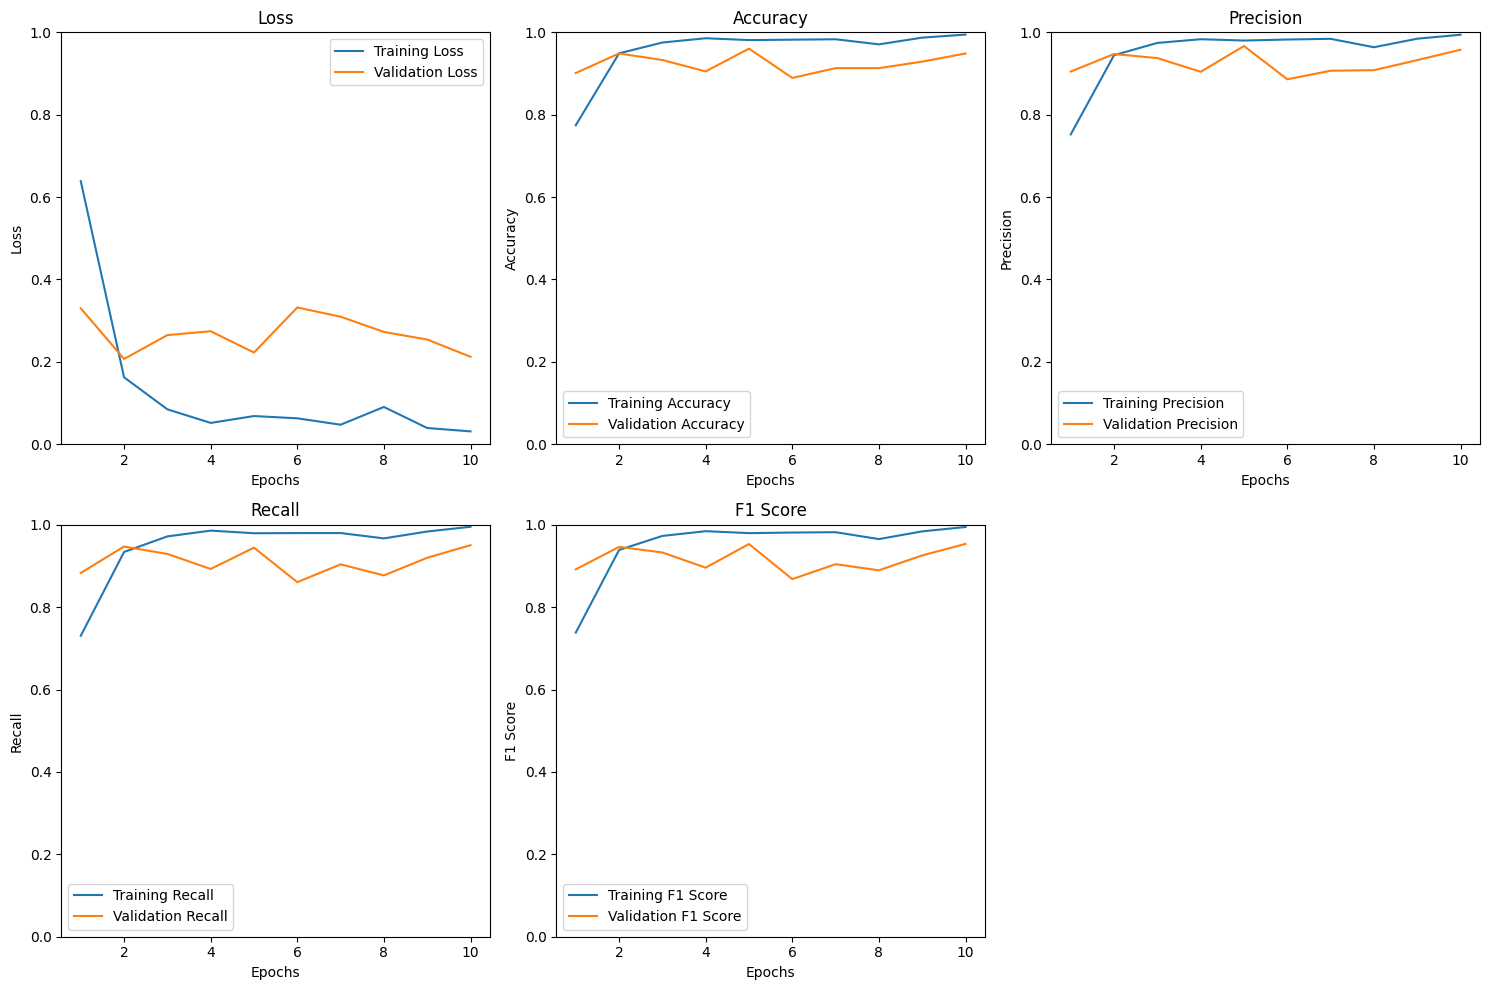

In [12]:
# Visualization of metrics
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(15, 10))

# Loss plot
plt.subplot(2, 3, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1

# Accuracy plot
plt.subplot(2, 3, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1

# Precision plot
plt.subplot(2, 3, 3)
plt.plot(epochs, train_precisions, label='Training Precision')
plt.plot(epochs, val_precisions, label='Validation Precision')
plt.title('Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1

# Recall plot
plt.subplot(2, 3, 4)
plt.plot(epochs, train_recalls, label='Training Recall')
plt.plot(epochs, val_recalls, label='Validation Recall')
plt.title('Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1

# F1 Score plot
plt.subplot(2, 3, 5)
plt.plot(epochs, train_f1_scores, label='Training F1 Score')
plt.plot(epochs, val_f1_scores, label='Validation F1 Score')
plt.title('F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1

# Adjust layout and show plot
plt.tight_layout()
plt.show()


In [13]:
# Test phase
model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        test_loss += loss.item() * inputs.size(0)
        
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss /= len(test_dataset)
test_accuracy = 100 * correct / total
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Test Loss: 0.2308, Test Accuracy: 94.47%


In [14]:
# Save the model's state dictionary
torch.save(model.state_dict(), 'models/resnet50_trash_model.pth')